In [1]:
#Do Install all the required Libraries, especially AstroML, or otherwise comments few sections

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from astroML.datasets import get_data_home
from astroML.datasets.tools import sql_query
import matplotlib.pyplot as plt
 #can comment this
tf.random.set_seed(7)

In [3]:
from astroML.datasets import fetch_sdss_galaxy_colors
#If not installed AstroML, then dont run this
#Using a Predefined Function

NOBJECTS = 10000

GAL_COLORS_NAMES = ['u', 'g', 'r', 'i', 'z', 'specClass',
                    'redshift', 'redshift_err']

ARCHIVE_FILE = 'sdss_galaxy_colors.npy'


def fetch_sdss_galaxy_colors(data_home=None, download_if_missing=True):
    """Loader for SDSS galaxy colors.
    This function directly queries the sdss SQL database at
    http://cas.sdss.org/
    Parameters
    ----------
    data_home : optional, default=None
        Specify another download and cache folder for the datasets. By default
        all astroML data is stored in '~/astroML_data'.
    download_if_missing : optional, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    Returns
    -------
    data : recarray, shape = (10000,)
        record array containing magnitudes and redshift for each galaxy
    """
    data_home = get_data_home(data_home)

    archive_file = os.path.join(data_home, ARCHIVE_FILE)

    query_text = ('\n'.join(("SELECT TOP %i" % 10000,
                             "  p.u, p.g, p.r, p.i, p.z, s.class, s.z, s.zerr",
                             "FROM PhotoObj AS p",
                             "  JOIN SpecObj AS s ON s.bestobjid = p.objid",
                             "WHERE ",
                             "  p.u BETWEEN 0 AND 20.6",
                             "  AND p.g BETWEEN 0 AND 21",
                             "  AND s.class <> 'UNKNOWN'",
                             "  AND s.class <> 'STAR'",
                             "  AND s.class <> 'SKY'",
                             "  AND s.class <> 'STAR_LATE'")))

    if not os.path.exists(archive_file):
        if not download_if_missing:
            raise IOError('data not present on disk. '
                          'set download_if_missing=True to download')

        print("querying for %i objects" % NOBJECTS)
        print(query_text)
        output = sql_query(query_text)
        print("finished.")

        kwargs = {'delimiter': ',', 'skip_header': 2,
                  'names': GAL_COLORS_NAMES, 'dtype': None,
                  'encoding': 'ascii',
                  }

        data = np.genfromtxt(output, **kwargs)
        np.save(archive_file, data)

    else:
        data = np.load(archive_file)

    return data

In [4]:
df1=fetch_sdss_galaxy_colors()
df1=pd.DataFrame(df1)
df1 #If not installed AstroML, then dont run this

,u,g,r,i,z,specClass,redshift,redshift_err
0,18.87367,17.10671,16.18420,15.71833,15.35918,GALAXY,0.057001,0.000013
1,17.94035,16.90945,16.57593,16.39091,16.23323,GALAXY,0.032501,0.000007
2,18.41108,17.03542,16.05840,15.61348,15.24383,GALAXY,0.074817,0.000020
3,17.44693,16.36448,15.93542,15.62058,15.46209,GALAXY,0.051699,0.000008
4,18.93923,17.53421,16.78974,16.39398,16.09739,GALAXY,0.094358,0.000011
...,...,...,...,...,...,...,...,...
49995,19.28396,17.94056,17.01705,16.56141,16.24133,GALAXY,0.183744,0.000029
49996,18.10312,16.88434,16.32386,15.97911,15.77122,GALAXY,0.060503,0.000015
49997,17.34780,16.49301,16.30405,16.19081,16.13920,GALAXY,0.033577,0.000005
49998,19.11034,19.01968,19.01015,18.88743,18.71547,QSO,2.006218,0.000482


In [5]:
df2=pd.read_excel(r"C:\Users\Vatsalya Sharan\Downloads\SSDS_s_g_q_50k.xlsx") #Import the training data set
df2.describe()

,u,g,r,i,z,redshift
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,18.596653,17.328194,16.802118,16.548426,16.389924,0.137375
std,0.863168,1.007017,1.149464,1.222183,1.299960,0.387857
min,11.624860,9.449155,8.677709,8.142487,8.406283,-0.004136
25%,18.134882,16.756590,16.120415,15.795423,15.551870,-0.000120
50%,18.839590,17.447580,16.826165,16.544185,16.366120,0.036483
75%,19.264713,18.004385,17.523907,17.283330,17.162590,0.086659
max,19.599980,19.991480,30.757110,31.468180,30.846780,6.991177


In [6]:
df_test=pd.read_excel(r"C:\Users\Vatsalya Sharan\Downloads\SDSS_5_25_test.xlsx")#Import the testing data set
df_test

,u,g,r,i,z,class,redshift
0,21.32026,20.15902,19.48748,19.23094,19.21059,STAR,0.000143
1,18.51505,17.42535,17.00923,16.80774,16.76218,STAR,-0.000081
2,19.53061,17.78513,17.15092,16.89634,16.76129,STAR,-0.000080
3,21.15226,20.26725,19.88219,19.67946,19.54277,GALAXY,-0.000844
4,20.09739,18.49096,17.80978,17.48587,17.37479,STAR,-0.000540
...,...,...,...,...,...,...,...
49995,19.53958,17.95210,17.32317,17.06732,16.93099,STAR,-0.000169
49996,16.41986,14.91807,14.30658,14.36867,13.95235,STAR,-0.000166
49997,23.77688,22.79934,20.92361,19.96983,19.32536,GALAXY,0.512071
49998,18.20514,16.31160,15.45632,15.03123,14.69489,GALAXY,0.034379


In [7]:
X=df2.drop('class',axis=1)
X_s=X/X.apply(max)
X_s.describe()

,u,g,r,i,z,redshift
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.948810,0.866779,0.546284,0.525878,0.531333,0.019650
std,0.044039,0.050372,0.037372,0.038839,0.042142,0.055478
min,0.593106,0.472659,0.282137,0.258753,0.272517,-0.000592
25%,0.925250,0.838187,0.524120,0.501949,0.504165,-0.000017
50%,0.961205,0.872751,0.547066,0.525743,0.530562,0.005218
75%,0.982894,0.900603,0.569751,0.549232,0.556382,0.012395
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


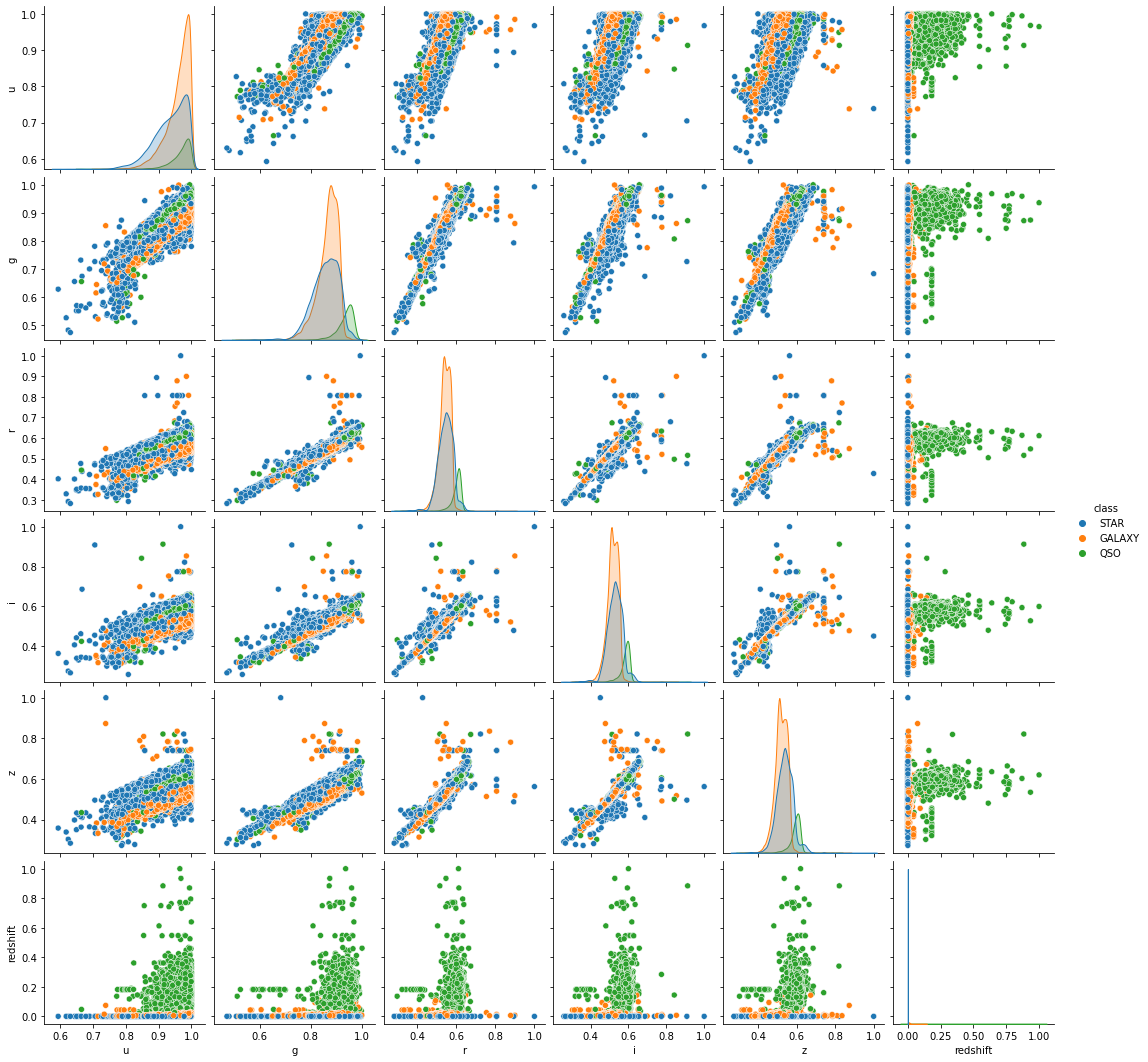

In [8]:
y2=df2.iloc[:,5]# taken from labelled data
y_s=pd.DataFrame(y2)
scaled=[X_s,y_s]
df2_sc=pd.concat(scaled,axis=1)
sns.pairplot(data=df2_sc,hue='class')#Plotting Training Data

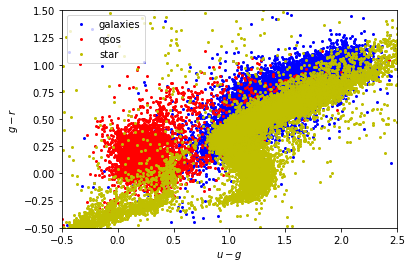

In [9]:
data = df2
data1 = data[::10]  # truncate for plotting

# Extract colors and spectral classG
ug = data['u'] - data['g']
gr = data['g'] - data['r']
spec_class = data['class']

galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')
star = (spec_class == 'STAR')

#------------------------------------------------------------
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

ax.plot(ug[galaxies], gr[galaxies], '.', ms=4, c='b', label='galaxies')
ax.plot(ug[qsos], gr[qsos], '.', ms=4, c='r', label='qsos')
ax.plot(ug[star],gr[star],'.',ms=4,c='y',label='star')

ax.legend(loc=2)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()#captures somewhat  linear relation

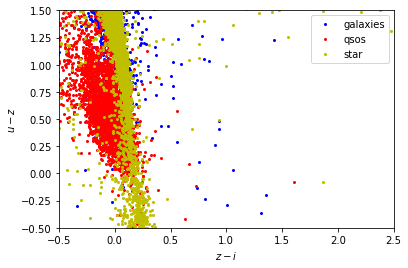

In [10]:
zi = data['z'] - data['i']
uz = data['u'] - data['z']
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

ax.plot(zi[galaxies], uz[galaxies], '.', ms=4, c='b', label='galaxies')
ax.plot(zi[qsos], uz[qsos], '.', ms=4, c='r', label='qsos')
ax.plot(zi[star],uz[star],'.',ms=4,c='y',label='star')

ax.legend(loc=2)

ax.set_xlabel('$z-i$')
ax.set_ylabel('$u-z$')
plt.legend()
plt.show()

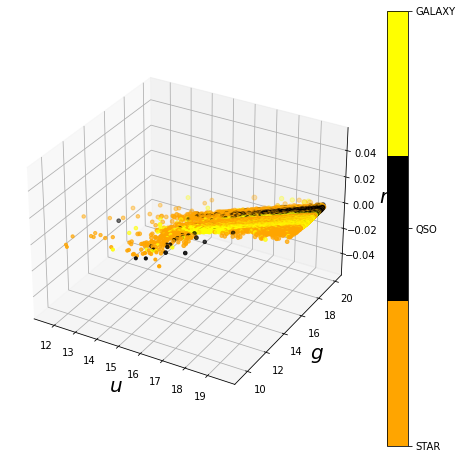

In [11]:
#3-D PLots
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
col=df2['class'].map({'STAR':0,'QSO':1,'GALAXY':2})
colors = ['orange','black','yellow']
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df2.u,df2.g,df2.r, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$u$',fontsize="20")
ax.set_ylabel('$g$',fontsize="20")
ax.set_zlabel('$r$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()


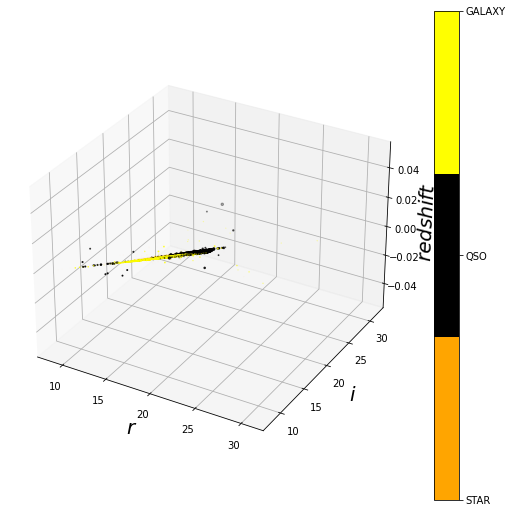

In [12]:
fig = plt.figure(figsize=(9,9))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df2.r,df2.i,df2.redshift, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$r$',fontsize="20")
ax.set_ylabel('$i$',fontsize="20")
ax.set_zlabel('$redshift$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

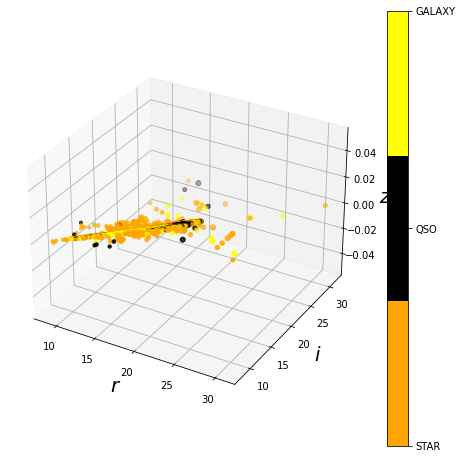

In [13]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df2.r,df2.i,df2.z, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$r$',fontsize="20")
ax.set_ylabel('$i$',fontsize="20")
ax.set_zlabel('$z$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

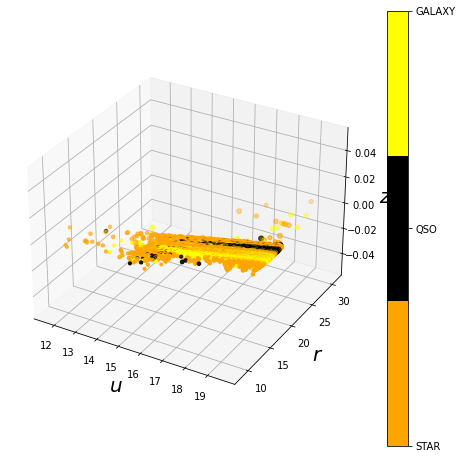

In [14]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df2.u,df2.r,df2.z, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$u$',fontsize="20")
ax.set_ylabel('$r$',fontsize="20")
ax.set_zlabel('$z$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

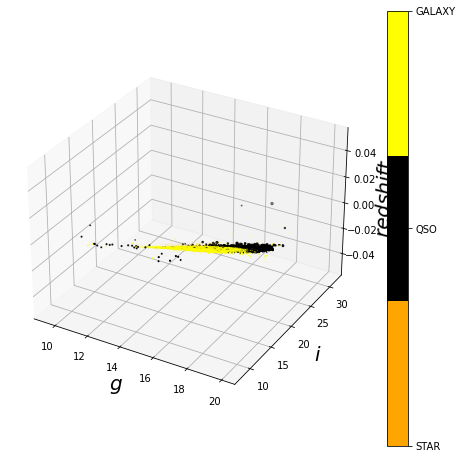

In [15]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df2.g,df2.i,df2.redshift, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$g$',fontsize="20")
ax.set_ylabel('$i$',fontsize="20")
ax.set_zlabel('$redshift$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

In [16]:
ytann=df_test['class']
ytann

0          STAR
1          STAR
2          STAR
3        GALAXY
4          STAR
          ...  
49995      STAR
49996      STAR
49997    GALAXY
49998    GALAXY
49999    GALAXY
Name: class, Length: 50000, dtype: object

In [17]:
X_t=df_test.drop('class',axis=1)
X_t_sc=X_t/X_t.apply(max)

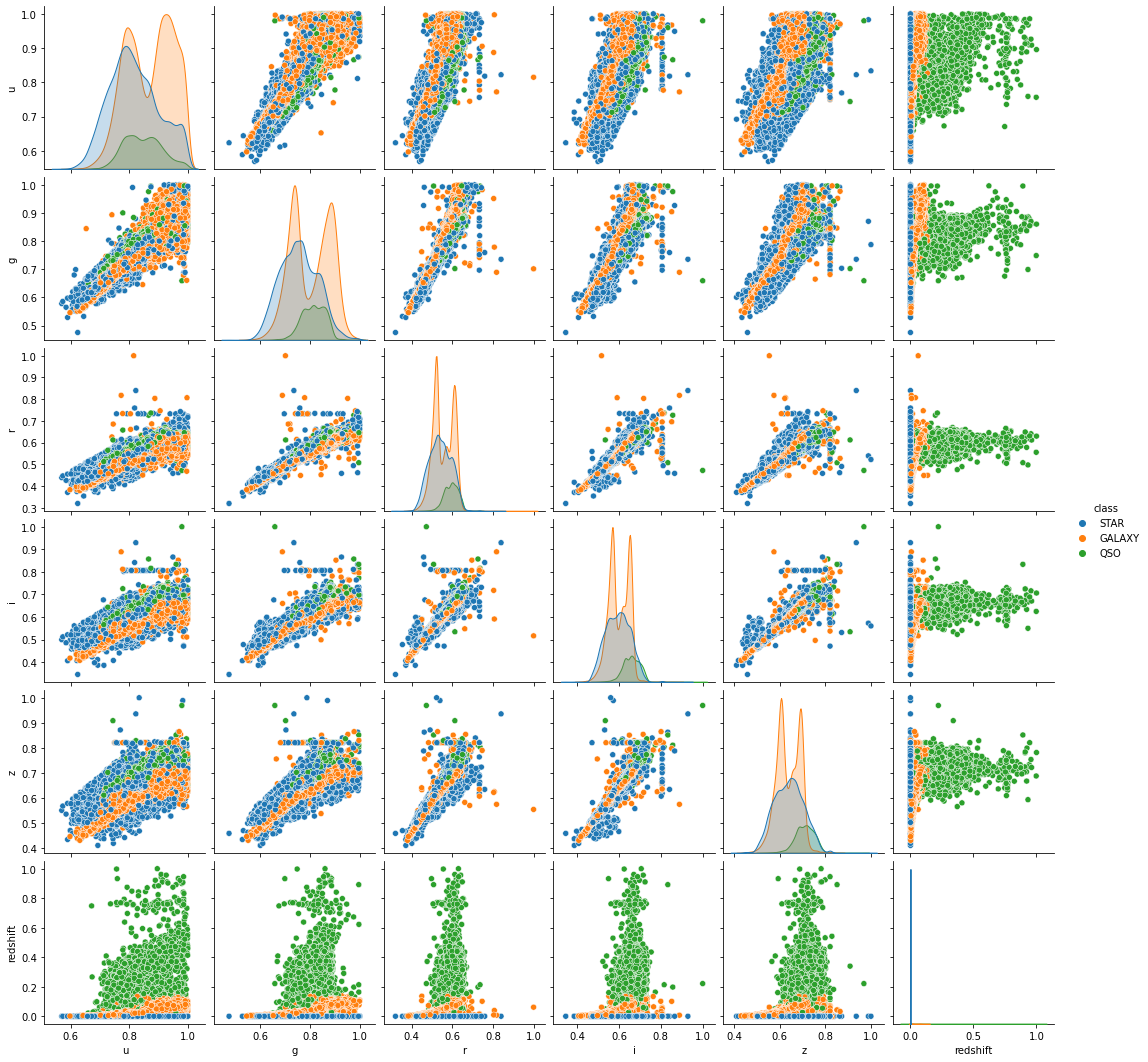

In [18]:
y_t=df_test.iloc[:,5]
y_t_sc=pd.DataFrame(y_t)
scaled=[X_t_sc,y_t_sc]
dftest_sc=pd.concat(scaled,axis=1)
sns.pairplot(data=dftest_sc,hue='class')#Plotting Testing Data

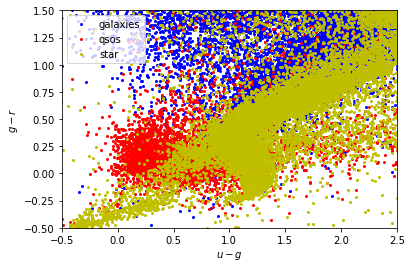

In [19]:
data = df_test
data1 = data[::10]  # truncate for plotting

# Extract colors and spectral classG
ug = data['u'] - data['g']
gr = data['g'] - data['r']
spec_class = data['class']

galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')
star = (spec_class == 'STAR')

#------------------------------------------------------------
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

ax.plot(ug[galaxies], gr[galaxies], '.', ms=4, c='b', label='galaxies')
ax.plot(ug[qsos], gr[qsos], '.', ms=4, c='r', label='qsos')
ax.plot(ug[star],gr[star],'.',ms=4,c='y',label='star')

ax.legend(loc=2)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()

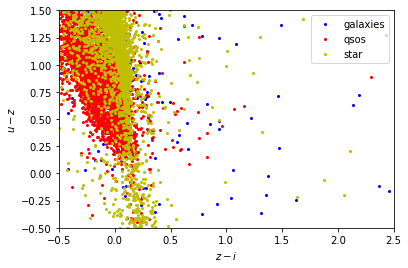

In [20]:
zi = data['z'] - data['i']
uz = data['u'] - data['z']
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 1.5)

ax.plot(zi[galaxies], uz[galaxies], '.', ms=4, c='b', label='galaxies')
ax.plot(zi[qsos], uz[qsos], '.', ms=4, c='r', label='qsos')
ax.plot(zi[star],uz[star],'.',ms=4,c='y',label='star')

ax.legend(loc=2)

ax.set_xlabel('$z-i$')
ax.set_ylabel('$u-z$')
plt.legend()
plt.show()

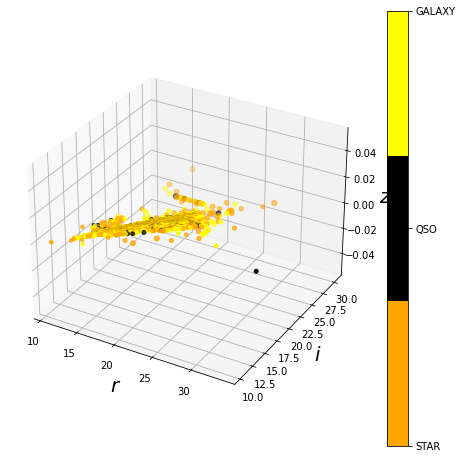

In [21]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df_test.r,df_test.i,df_test.z, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$r$',fontsize="20")
ax.set_ylabel('$i$',fontsize="20")
ax.set_zlabel('$z$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

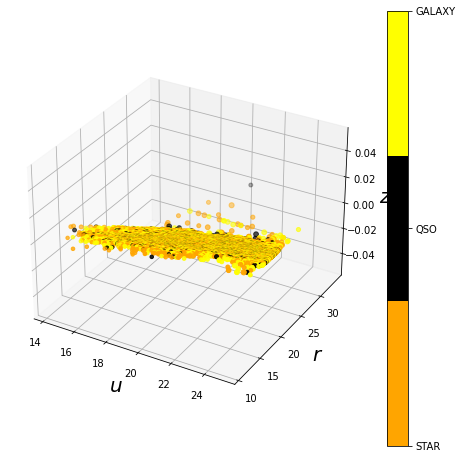

In [22]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
plt.scatter(df_test.u,df_test.r,df_test.z, c=col, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('$u$',fontsize="20")
ax.set_ylabel('$r$',fontsize="20")
ax.set_zlabel('$z$',fontsize="20")
cb = plt.colorbar()
cb.set_ticks([0,1,2])
cb.set_ticklabels(["STAR", "QSO", "GALAXY"])
plt.show()

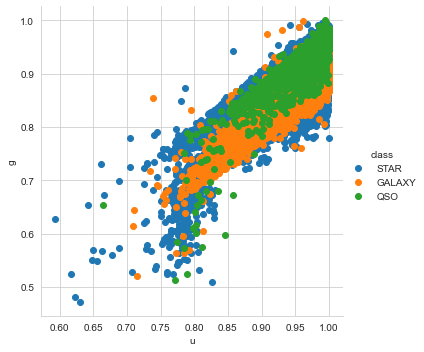

In [23]:
sns.set_style('whitegrid');#To emphasize linear relationship
sns.FacetGrid(df2_sc, hue='class', height=5) \
.map(plt.scatter, 'u', 'g') \
.add_legend();
plt.show()

In [24]:
scalar=StandardScaler().fit(X)
X_scaled=scalar.transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled


,0,1,2,3,4,5
0,-0.018065,-0.091711,-0.023557,0.036626,0.097532,-0.353550
1,0.317586,0.315605,0.326279,0.348882,0.396136,-0.353979
2,-0.355314,-0.424648,-0.257904,-0.167347,-0.098407,-0.354249
3,1.118677,-0.256288,-0.727449,-0.828597,-0.851545,-0.354407
4,0.766761,-0.890633,-1.449175,-1.502202,-1.710872,-0.353623
...,...,...,...,...,...,...
49995,0.984728,0.282854,-0.123648,-0.308604,-0.454898,0.011416
49996,0.426418,0.383201,0.314682,0.266390,0.321664,-0.258978
49997,-0.181928,-0.649502,-0.786059,-0.803707,-0.785096,-0.355345
49998,0.653954,0.882264,0.955640,1.007375,1.048463,-0.355539


In [25]:
#Mapping Classes to Integers
df2_sc['class'] = df2_sc['class'].map({'STAR' :0, 'GALAXY':1,'QSO':2}).astype(int) #mapping numbers #stay consistent
df2_sc

,u,g,r,i,z,redshift,class
0,0.948014,0.862159,0.545404,0.527301,0.535444,0.000036,0
1,0.962796,0.882677,0.558478,0.539428,0.548027,0.000012,0
2,0.933162,0.845389,0.536646,0.519379,0.527186,-0.000003,0
3,0.998075,0.853869,0.519098,0.493697,0.495447,-0.000012,0
4,0.982577,0.821916,0.492126,0.467535,0.459234,0.000032,0
...,...,...,...,...,...,...,...
49995,0.992176,0.881027,0.541663,0.513892,0.512163,0.020283,1
49996,0.967589,0.886081,0.558044,0.536224,0.544889,0.005282,1
49997,0.940798,0.834062,0.516907,0.494663,0.498248,-0.000064,0
49998,0.977609,0.911220,0.581998,0.565003,0.575518,-0.000075,0


In [26]:
y2

0          STAR
1          STAR
2          STAR
3          STAR
4          STAR
          ...  
49995    GALAXY
49996    GALAXY
49997      STAR
49998      STAR
49999    GALAXY
Name: class, Length: 50000, dtype: object

In [27]:
y_n=df2_sc.iloc[:,6]

y_ndf=pd.DataFrame(y_n)
y_ndf

,class
0,0
1,0
2,0
3,0
4,0
...,...
49995,1
49996,1
49997,0
49998,0


In [28]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
encoder = LabelEncoder()
encoder.fit(y2)#taken from labeled data
encoded_Y_ts = encoder.transform(y2)
#convert integers to dummy variables (i.e. one hot encoded)
y1 = np_utils.to_categorical(encoded_Y_ts)
y1

Using TensorFlow backend.


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_s.values, y1, test_size=0.25, random_state=42)
y_test#Encoded #Scaled #Spliting the Data

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_s , y_n, test_size=0.25, random_state=42)
y_test2#Not Encoded # Scaled 

33553    1
9427     0
199      0
12447    1
39489    1
        ..
9771     1
34737    0
30390    0
6797     1
37270    1
Name: class, Length: 12500, dtype: int32

In [31]:
#Encoding
encoder = LabelEncoder()
encoder.fit(ytann)
encoded_yann = encoder.transform(ytann)
#convert integers to dummy variables (i.e. one hot encoded)
yann_t = np_utils.to_categorical(encoded_yann)
yann_t

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [32]:
Xt=df_test.drop('class',axis=1)

In [33]:
Xt_s=Xt/Xt.apply(max)
yt=df_test['class']#labeled

In [34]:
Xt_s.describe()

,u,g,r,i,z,redshift
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.845666,0.784071,0.551117,0.601608,0.643456,0.046532
std,0.084105,0.079874,0.052122,0.054891,0.059904,0.087529
min,0.568866,0.475684,0.320046,0.345540,0.409585,-0.001150
25%,0.781678,0.725412,0.512809,0.560941,0.599056,-0.000011
50%,0.838898,0.776266,0.550683,0.603497,0.645508,0.013202
75%,0.916468,0.852101,0.597920,0.646738,0.688964,0.064266
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
scalart=StandardScaler().fit(Xt)
X_scaledt=scalart.transform(Xt)
X_scaledt =pd.DataFrame(X_scaledt)
X_scaledt

,0,1,2,3,4,5
0,0.084980,0.283083,0.473086,0.636090,0.783204,-0.531388
1,-1.249176,-1.086468,-0.931758,-0.825102,-0.685638,-0.531753
2,-0.766176,-0.906221,-0.851438,-0.771676,-0.686172,-0.531751
3,0.005080,0.337305,0.696835,0.906548,0.982485,-0.532997
4,-0.496616,-0.552604,-0.477951,-0.416189,-0.318123,-0.532501
...,...,...,...,...,...,...
49995,-0.761910,-0.822570,-0.753795,-0.668575,-0.584366,-0.531898
49996,-2.245647,-2.342599,-2.463807,-2.295864,-2.371303,-0.531891
49997,1.253347,1.605866,1.287184,1.081641,0.852057,0.303386
49998,-1.396569,-1.644450,-1.812055,-1.896339,-1.925841,-0.475560


In [36]:
#Scaled Test data with Labels
scaledt=[Xt_s,yt]
dft_sc=pd.concat(scaledt,axis=1)
dft_sc #With Labels

,u,g,r,i,z,redshift,class
0,0.852813,0.806682,0.575775,0.636523,0.690373,0.000020,STAR
1,0.740604,0.697292,0.502553,0.556318,0.602384,-0.000012,STAR
2,0.781227,0.711688,0.506739,0.559250,0.602352,-0.000011,STAR
3,0.846093,0.811013,0.587437,0.651368,0.702310,-0.000120,GALAXY
4,0.803898,0.739933,0.526206,0.578763,0.624399,-0.000077,STAR
...,...,...,...,...,...,...,...
49995,0.781585,0.718370,0.511828,0.564909,0.608451,-0.000024,STAR
49996,0.656796,0.596960,0.422700,0.475587,0.501407,-0.000024,STAR
49997,0.951078,0.912337,0.618206,0.660979,0.694497,0.073087,GALAXY
49998,0.728208,0.652724,0.456671,0.497517,0.528092,0.004907,GALAXY


In [37]:
dft_sc['class'] = dft_sc['class'].map({'STAR' :0, 'GALAXY':1,'QSO':2}).astype(int) #mapping numbers
dft_sc#test data with numbers as labels

,u,g,r,i,z,redshift,class
0,0.852813,0.806682,0.575775,0.636523,0.690373,0.000020,0
1,0.740604,0.697292,0.502553,0.556318,0.602384,-0.000012,0
2,0.781227,0.711688,0.506739,0.559250,0.602352,-0.000011,0
3,0.846093,0.811013,0.587437,0.651368,0.702310,-0.000120,1
4,0.803898,0.739933,0.526206,0.578763,0.624399,-0.000077,0
...,...,...,...,...,...,...,...
49995,0.781585,0.718370,0.511828,0.564909,0.608451,-0.000024,0
49996,0.656796,0.596960,0.422700,0.475587,0.501407,-0.000024,0
49997,0.951078,0.912337,0.618206,0.660979,0.694497,0.073087,1
49998,0.728208,0.652724,0.456671,0.497517,0.528092,0.004907,1


In [38]:
y_ts=dft_sc.iloc[:,6]
y_ts

0        0
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    1
49998    1
49999    1
Name: class, Length: 50000, dtype: int32

# Linear Regression Model

In [39]:
#Linear regression
clf_linear = LinearRegression().fit(X_train2, y_train2)
#print(f"score of logistic method: {clf_linear.score(X_test, y_test)}")
yc = np.round(X_test2.dot(clf_linear.coef_.T)+clf_linear.intercept_)
yplinr = np.round(clf_linear.predict(X_test2))
assert np.array_equal(yc,yplinr) == True

acc_linear = np.sum(yc == y_test2)/y_test2.shape[0]
print(f"accuracy of linear method: {acc_linear}")


accuracy of linear method: 0.84976


In [40]:
yc

33553    1.0
9427     0.0
199      0.0
12447    1.0
39489    1.0
        ... 
9771     1.0
34737    0.0
30390    0.0
6797     1.0
37270    1.0
Length: 12500, dtype: float64

In [41]:
yplinr

array([1., 0., 0., ..., 0., 1., 1.])

In [42]:
yct=np.round(Xt_s.dot(clf_linear.coef_.T)+clf_linear.intercept_)
yplinrt = np.round(clf_linear.predict(Xt_s))
assert np.array_equal(yct,yplinrt) == True

acc_linear_t = np.sum(yct == y_ts)/y_ts.shape[0]
print(f"accuracy of linear method: {acc_linear_t}")#It fails Miserably

accuracy of linear method: 0.0034


IMPLEMENTING LASSO REGULARISATION

In [43]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_error  # we will use MSE for evaluation
import matplotlib.pyplot as plt

In [44]:
lasso = Lasso(alpha=0.0001, fit_intercept=False, max_iter=10000)
lasso.fit(X_train2, y_train2)

Lasso(alpha=0.0001, fit_intercept=False, max_iter=10000)

In [45]:
lasso.coef_

array([ -4.87047   ,  15.31273125,   3.65212471,  -7.31819817,
       -11.7823402 ,   6.56871841])

In [46]:
ylas = np.round(X_test2.dot(lasso.coef_.T)+lasso.intercept_)
acc_linearlas = np.sum(ylas == y_test2)/y_test2.shape[0]
acc_linearlas

0.83856

In [47]:
ylast = np.round(Xt_s.dot(lasso.coef_.T)+lasso.intercept_)
acc_linearlast = np.sum(ylast == y_ts)/y_ts.shape[0]
acc_linearlast

0.00408

In [48]:
def plot_errors(lambdas, train_errors, test_errors, title):
    plt.figure(figsize=(16, 9))
    plt.plot(lambdas, train_errors, label="train")
    plt.plot(lambdas, test_errors, label="test")
    plt.xlabel("$\\lambda$", fontsize=14)
    plt.ylabel("MSE", fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.show()

In [49]:
def evaluate_model(Model, lambdas):
    training_errors = [] # we will store the error on the training set, for using each different lambda
    testing_errors = [] # and the error on the testing set
    for l in lambdas:
        # in sklearn, they refer to lambda as alpha, the name is different in different literature
        # Model will be either Lasso, Ridge or ElasticNet
        model = Model(alpha=l, max_iter=1000) # we allow max number of iterations until the model converges
        model.fit(X_train2, y_train2)

        training_predictions = model.predict(X_train2)
        training_mse = mean_squared_error(y_train2, training_predictions)
        training_errors.append(training_mse)

        testing_predictions = model.predict(X_test2)
        testing_mse = mean_squared_error(y_test2, testing_predictions)
        testing_errors.append(testing_mse)
    return training_errors, testing_errors

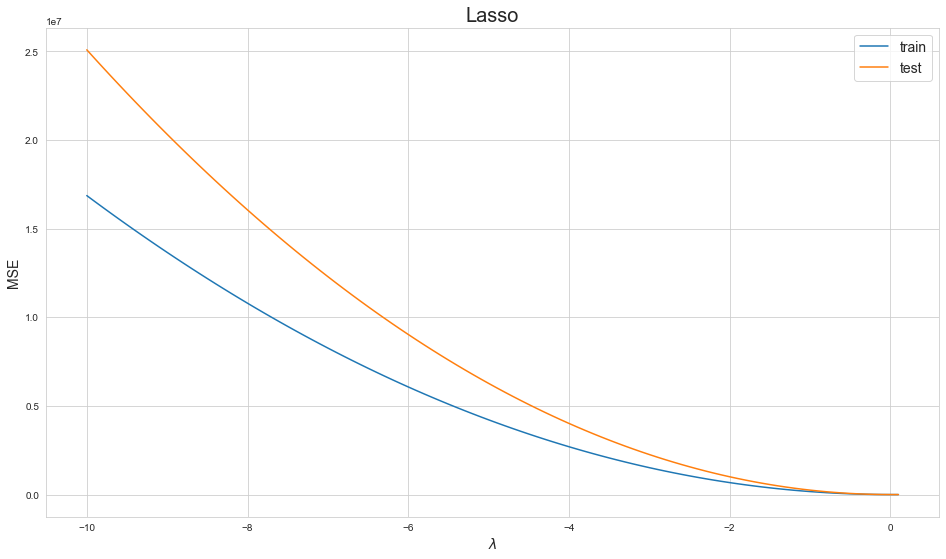

In [50]:
lambdas = np.arange(-10, 0.2, step=0.1)
lasso_train, lasso_test = evaluate_model(Lasso, lambdas)
plot_errors(lambdas, lasso_train, lasso_test, "Lasso")

Implementing Ridge Regularization

In [51]:
#Ridge Regularization
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=0.01, fit_intercept=False)
ridge.fit(X_train2, y_train2)
ridge.coef_


array([ -6.27942643,  16.23455587,   8.97065696,  -8.3741825 ,
       -15.1863731 ,   6.33982974])

In [52]:
yrig = np.round(X_test2.dot(ridge.coef_.T)+ridge.intercept_)
acc_linearig = np.sum(yrig == y_test2)/y_test2.shape[0]
acc_linearig

0.85232

# Testing regression for the feature redshift

In [53]:
linX=X_s.iloc[:,0:5]
linX


,u,g,r,i,z
0,0.948014,0.862159,0.545404,0.527301,0.535444
1,0.962796,0.882677,0.558478,0.539428,0.548027
2,0.933162,0.845389,0.536646,0.519379,0.527186
3,0.998075,0.853869,0.519098,0.493697,0.495447
4,0.982577,0.821916,0.492126,0.467535,0.459234
...,...,...,...,...,...
49995,0.992176,0.881027,0.541663,0.513892,0.512163
49996,0.967589,0.886081,0.558044,0.536224,0.544889
49997,0.940798,0.834062,0.516907,0.494663,0.498248
49998,0.977609,0.911220,0.581998,0.565003,0.575518


In [54]:
liny=X_s.iloc[:,5]
liny

0        0.000036
1        0.000012
2       -0.000003
3       -0.000012
4        0.000032
           ...   
49995    0.020283
49996    0.005282
49997   -0.000064
49998   -0.000075
49999    0.005463
Name: redshift, Length: 50000, dtype: float64

In [55]:
X_train_lin,X_test_lin,y_train_lin,y_test_lin=train_test_split(linX, liny, test_size=0.25, random_state=42)
y_test_lin

33553    0.002129
9427    -0.000035
199     -0.000038
12447    0.006497
39489    0.013580
           ...   
9771     0.006854
34737    0.000032
30390   -0.000035
6797     0.009072
37270    0.006662
Name: redshift, Length: 12500, dtype: float64

In [56]:
linreg = LinearRegression().fit(X_train_lin, y_train_lin)

print(linreg.score(X_test_lin, y_test_lin))



0.26170063724426473


In [57]:
linypred=linreg.predict(X_test_lin)
mse=np.sum(y_test_lin-linypred)**2
mse**0.5 #Standard Scaling Doesn't improve the result for this case at least

12.296181202615184

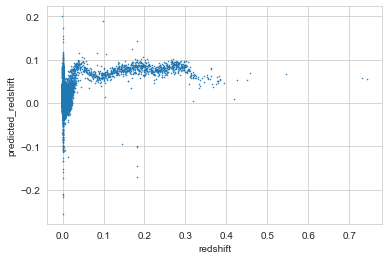

In [58]:
plt.scatter(y_test_lin,linypred, s=0.3)
plt.xlabel('redshift')
plt.ylabel('predicted_redshift')
plt.show()

# Logistic Regression Model


In [59]:
#basic model
modellr = LogisticRegression()  #Create an instance of the model.

modellr.fit(X_train2, y_train2)  # Train the model using training data

ypredlr = modellr.predict(X_test2)

print ("Accuracy = ",metrics.accuracy_score(y_test2, ypredlr))

Accuracy =  0.85984


In [60]:
modellro = LogisticRegression(penalty='l1',solver='saga',max_iter=10000,tol=1e-4, class_weight='balanced',random_state=0)  #Create an instance of the model.

modellro.fit(X_train2, y_train2)  # Train the model using training data

ypredlro = modellro.predict(X_test2)

print ("Accuracy = ",metrics.accuracy_score(y_test2, ypredlro))
#takes time tho #mention this

Accuracy =  0.98232


Cross Validation

In [61]:

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset

# prepare the cross-validation procedure
cvlr = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model

# evaluate model
scores = cross_val_score(modellro, X_train2, y_train2, scoring='accuracy', cv=cvlr, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.979 (0.002)


In [62]:
def acc_gen(y_test,y_pred):
    result = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, y_pred,zero_division=1)
    print("Classification Report:")
    print (result1)
    result2 = accuracy_score(y_test,y_pred)
    print("Accuracy:",result2)

In [63]:
acc_gen(y_test2,ypredlro) #optimized model on training (test part)

Confusion Matrix:
[[5263    0   12]
 [ 132 6053   34]
 [   1   42  963]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5275
           1       0.99      0.97      0.98      6219
           2       0.95      0.96      0.96      1006

    accuracy                           0.98     12500
   macro avg       0.97      0.98      0.98     12500
weighted avg       0.98      0.98      0.98     12500

Accuracy: 0.98232


In [64]:
ypredlro_t=modellro.predict(Xt_s)
acc_gen(y_ts,ypredlro_t) #optimized model on the testing dataset

Confusion Matrix:
[[20024     0     5]
 [  481 18496  6259]
 [    2   257  4476]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20029
           1       0.99      0.73      0.84     25236
           2       0.42      0.95      0.58      4735

    accuracy                           0.86     50000
   macro avg       0.79      0.89      0.80     50000
weighted avg       0.93      0.86      0.87     50000

Accuracy: 0.85992


<AxesSubplot:>

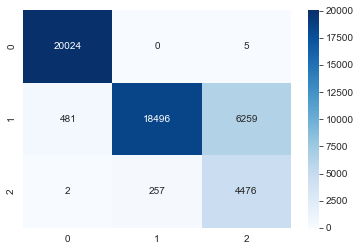

In [65]:
import seaborn as sns
cnfm = confusion_matrix(y_ts,ypredlro_t)

sns.heatmap(cnfm, cmap ='Blues', annot = True,fmt='d')

# SVM Model Implementaion

In [66]:
#basic model
svm_k=svm.SVC()#takes a bit of time
svm_k.fit(X_train2, y_train2)
ypredsvm = svm_k.predict(X_test2)
print ("Accuracy = ", metrics.accuracy_score(y_test2, ypredsvm))

Accuracy =  0.95168


In [67]:
acc_gen(y_test2,ypredsvm)

Confusion Matrix:
[[5149  126    0]
 [ 366 5841   12]
 [   2   98  906]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5275
           1       0.96      0.94      0.95      6219
           2       0.99      0.90      0.94      1006

    accuracy                           0.95     12500
   macro avg       0.96      0.94      0.95     12500
weighted avg       0.95      0.95      0.95     12500

Accuracy: 0.95168


In [68]:
df20=df2_sc[::10]
X20=df20.drop('class',axis=1)
y20=df20['class']

In [69]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X20,y20, test_size=0.2, random_state=42)
y_test3 #Truncated Data Set for Parameter Grid Search

15010    0
25860    1
26530    0
10550    2
7050     0
        ..
47110    1
23130    1
32140    2
27320    1
19260    0
Name: class, Length: 1000, dtype: int32

In [70]:
#Optimizing model
param_grid = {'C': [0.01,0.1, 1, 10, 100, 500,1000],  
              #'gamma': [1, 0.1, 0.08, 0.05, 0.02, 0.01, 0.001], 
              #'coef0' : [10, 1, 0.1, 0.08, 0.05, 0.02, 0.01, 0.001],
              'kernel': ['linear','poly', 'rbf', 'sigmoid']} 

#Do it on much smaller data set
grid = GridSearchCV(SVC(class_weight = 'balanced'), param_grid, verbose = False, cv = 5) 



# fitting the model for grid search 
grid.fit(X_train3, y_train3) 
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X_test3) 
  
# print classification report 
print(classification_report(y_test3, grid_predictions)) 

{'C': 500, 'kernel': 'poly'}
SVC(C=500, class_weight='balanced', kernel='poly')
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       401
           1       1.00      0.98      0.99       514
           2       0.97      0.98      0.97        85

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [71]:
svm_ko=svm.SVC(C=500,class_weight='balanced',kernel='poly')#takes a bit of time #Searched Using Param Grid
svm_ko.fit(X_train2, y_train2)
ypredsvmo = svm_ko.predict(X_test2)
print ("Accuracy = ", metrics.accuracy_score(y_test2, ypredsvmo))

Accuracy =  0.9916


In [72]:
# prepare the cross-validation procedure
cvsvm = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model

# evaluate model
scores = cross_val_score(svm_ko, X_train2, y_train2, scoring='accuracy', cv=cvsvm, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.990 (0.001)


In [73]:
ypredsvm_t=svm_ko.predict(Xt_s)
acc_gen(y_ts,ypredsvm_t)#Not the best for classifying Quasars

Confusion Matrix:
[[20029     0     0]
 [  214 24761   261]
 [    2  1362  3371]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20029
           1       0.95      0.98      0.96     25236
           2       0.93      0.71      0.81      4735

    accuracy                           0.96     50000
   macro avg       0.96      0.90      0.92     50000
weighted avg       0.96      0.96      0.96     50000

Accuracy: 0.96322


<AxesSubplot:>

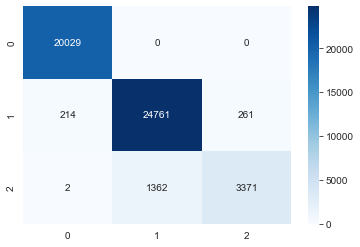

In [74]:
cnfm_svm = confusion_matrix(y_ts,ypredsvm_t)

sns.heatmap(cnfm_svm, cmap ='Blues', annot = True, fmt='d')

# Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=100,random_state=42,criterion='gini')
rfc.fit(X_train2,y_train2)
y_predrf=rfc.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_predrf))

Accuracy: 0.99208


In [76]:
acc_gen(y_test2,y_predrf)

Confusion Matrix:
[[5274    1    0]
 [  24 6181   14]
 [   1   59  946]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5275
           1       0.99      0.99      0.99      6219
           2       0.99      0.94      0.96      1006

    accuracy                           0.99     12500
   macro avg       0.99      0.98      0.98     12500
weighted avg       0.99      0.99      0.99     12500

Accuracy: 0.99208


In [77]:

cvsrf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model

# evaluate model
scores = cross_val_score(rfc, X_train2, y_train2, scoring='accuracy', cv=cvsrf, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.991 (0.001)


In [78]:
ypredrf_t=rfc.predict(Xt_s)
ypredrf_t
acc_gen(y_ts,ypredrf_t) #problem in classifying galaxies

Confusion Matrix:
[[20029     0     0]
 [  199 10130 14907]
 [    2   127  4606]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20029
           1       0.99      0.40      0.57     25236
           2       0.24      0.97      0.38      4735

    accuracy                           0.70     50000
   macro avg       0.74      0.79      0.65     50000
weighted avg       0.92      0.70      0.72     50000

Accuracy: 0.6953


<AxesSubplot:>

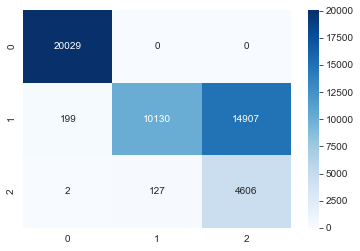

In [79]:
cnfm_rf = confusion_matrix(y_ts,ypredrf_t)

sns.heatmap(cnfm_rf, cmap ='Blues', annot = True, fmt='d')

In [80]:
rfcn=RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=None,
                           min_samples_split=3, min_samples_leaf=3, min_weight_fraction_leaf=0.0,
                           max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                           random_state=0, verbose=0, warm_start=False, class_weight='balanced',
                           ccp_alpha=0.0, max_samples=None)
rfcn.fit(X_train2,y_train2)
y_predrfn=rfcn.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_predrfn))
ypredrf_nt=rfcn.predict(Xt_s)
acc_gen(y_ts,ypredrf_nt)
#entropy decrease

Accuracy: 0.99152
Confusion Matrix:
[[20029     0     0]
 [  199  7768 17269]
 [    2    55  4678]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20029
           1       0.99      0.31      0.47     25236
           2       0.21      0.99      0.35      4735

    accuracy                           0.65     50000
   macro avg       0.73      0.77      0.61     50000
weighted avg       0.92      0.65      0.67     50000

Accuracy: 0.6495


# Artificial Neural Network

In [81]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X.values, y1, test_size=0.25, random_state=1)
y_test4 #Not scaled

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [82]:
X_train4

array([[1.858147e+01, 1.715407e+01, 1.655908e+01, 1.632717e+01,
        1.619329e+01, 2.928813e-05],
       [1.778729e+01, 1.591534e+01, 1.508550e+01, 1.469475e+01,
        1.436955e+01, 3.134977e-02],
       [1.956062e+01, 1.848883e+01, 1.770963e+01, 1.729259e+01,
        1.712075e+01, 1.828580e-01],
       ...,
       [1.782985e+01, 1.594588e+01, 1.510547e+01, 1.469562e+01,
        1.435781e+01, 3.442689e-02],
       [1.939519e+01, 1.926367e+01, 1.898432e+01, 1.855752e+01,
        1.857404e+01, 1.838123e+00],
       [1.891140e+01, 1.687070e+01, 1.585019e+01, 1.535828e+01,
        1.495706e+01, 7.033522e-02]])

In [83]:
#Generating a Basic Model Now this model is tuned
modelann=Sequential()
modelann.add(Dense(256,activation='relu'))
modelann.add(Dropout(rate=0.2))
modelann.add(Dense(128,activation='relu'))
modelann.add(Dropout(rate=0.2))
modelann.add(Dense(64,activation='relu'))
modelann.add(Dense(64,activation='relu'))
modelann.add(Dense(3,activation='softmax'))#128 gives adam and adagrad

In [84]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',patience=10,mode='min')

In [85]:
def plot_training_history(history, model, loss_function, optimizer):
    figure = plt.figure()
    figure.suptitle(loss_function)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()
    
    figure.tight_layout()
    plt.show()
    
    loss, accuracy  = model.evaluate(X_test4,y_test4, verbose=False)
    model.evaluate(Xt.values,yann_t)
    
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    print(optimizer)

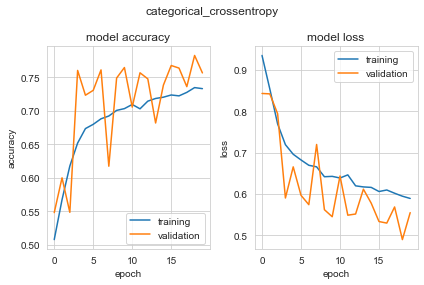

50000/50000 [==============================] - 2s 30us/sample - loss: 0.6262 - accuracy: 0.7520
Test loss: 0.555
Test accuracy: 0.757
sgd


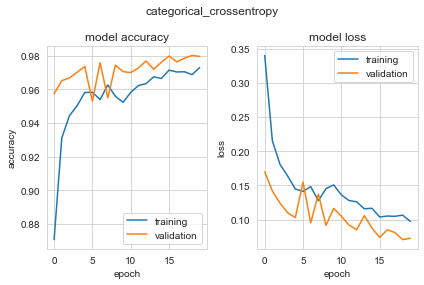

50000/50000 [==============================] - 2s 45us/sample - loss: 0.3106 - accuracy: 0.8581
Test loss: 0.0727
Test accuracy: 0.98
adam


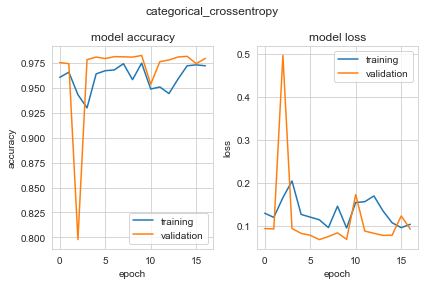

50000/50000 [==============================] - 2s 35us/sample - loss: 0.1521 - accuracy: 0.9531
Test loss: 0.0931
Test accuracy: 0.979
nadam


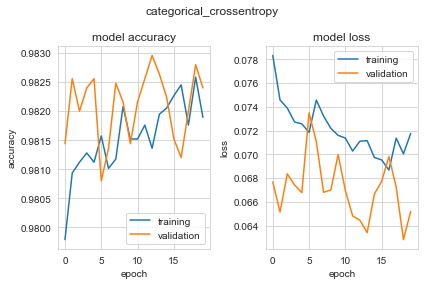

50000/50000 [==============================] - 1s 30us/sample - loss: 0.1348 - accuracy: 0.9546
Test loss: 0.0652
Test accuracy: 0.982
adagrad


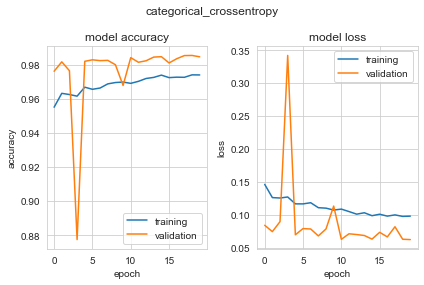

50000/50000 [==============================] - 1s 29us/sample - loss: 0.1467 - accuracy: 0.9510
Test loss: 0.062
Test accuracy: 0.985
rmsprop


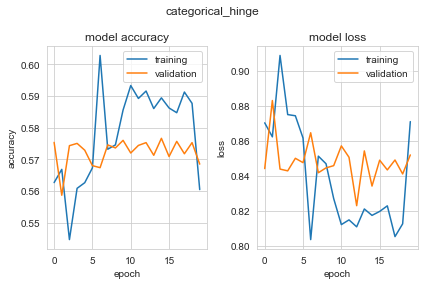

50000/50000 [==============================] - 1s 28us/sample - loss: 0.8295 - accuracy: 0.5819
Test loss: 0.852
Test accuracy: 0.568
sgd


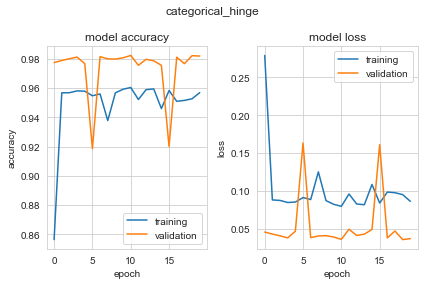

50000/50000 [==============================] - 2s 32us/sample - loss: 0.4472 - accuracy: 0.7767
Test loss: 0.0368
Test accuracy: 0.982
adam


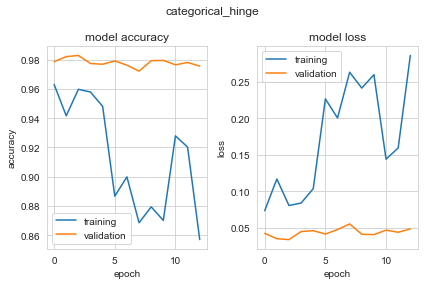

50000/50000 [==============================] - 1s 26us/sample - loss: 0.5430 - accuracy: 0.7286
Test loss: 0.0488
Test accuracy: 0.976
nadam


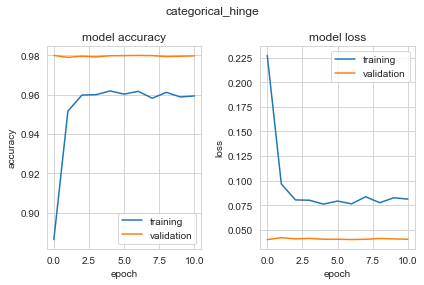

50000/50000 [==============================] - 1s 26us/sample - loss: 0.5717 - accuracy: 0.7142
Test loss: 0.0403
Test accuracy: 0.98
adagrad


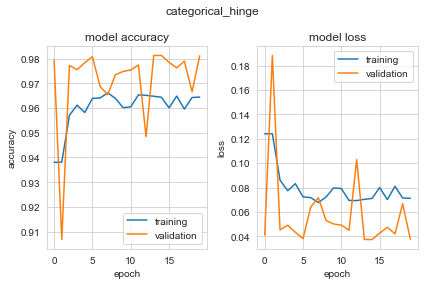

50000/50000 [==============================] - 1s 27us/sample - loss: 0.2924 - accuracy: 0.8538
Test loss: 0.0377
Test accuracy: 0.981
rmsprop


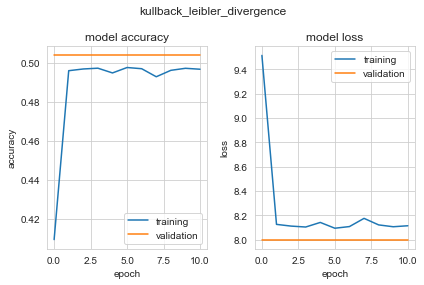

50000/50000 [==============================] - 1s 29us/sample - loss: 7.9830 - accuracy: 0.5047
Test loss: 8.0
Test accuracy: 0.504
sgd


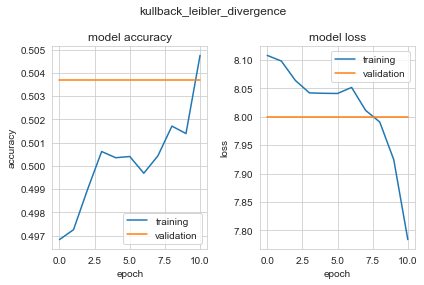

50000/50000 [==============================] - 1s 25us/sample - loss: 7.9830 - accuracy: 0.5047
Test loss: 8.0
Test accuracy: 0.504
adam


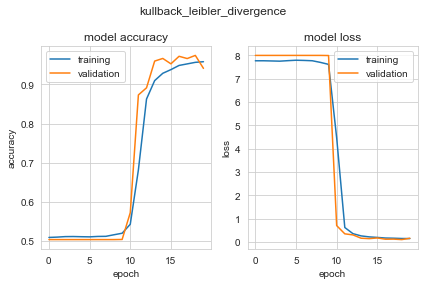

50000/50000 [==============================] - 1s 30us/sample - loss: 0.9126 - accuracy: 0.7733
Test loss: 0.154
Test accuracy: 0.941
nadam


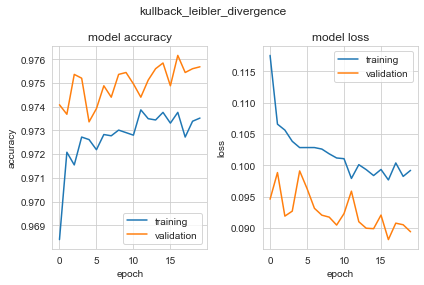

50000/50000 [==============================] - 2s 32us/sample - loss: 0.6357 - accuracy: 0.7994
Test loss: 0.0894
Test accuracy: 0.976
adagrad


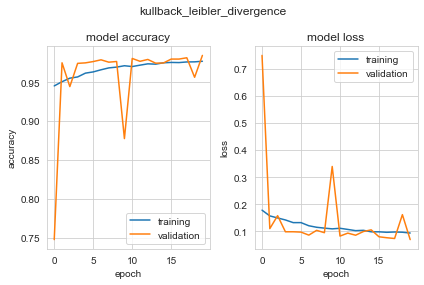

50000/50000 [==============================] - 2s 31us/sample - loss: 0.4449 - accuracy: 0.8638
Test loss: 0.0689
Test accuracy: 0.985
rmsprop


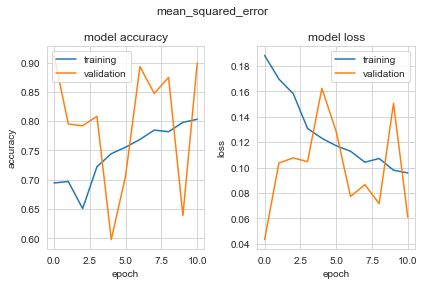

50000/50000 [==============================] - 1s 26us/sample - loss: 0.1787 - accuracy: 0.7007
Test loss: 0.0609
Test accuracy: 0.899
sgd


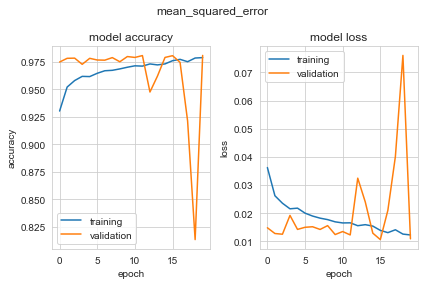

50000/50000 [==============================] - 1s 30us/sample - loss: 0.1161 - accuracy: 0.8055
Test loss: 0.0109
Test accuracy: 0.981
adam


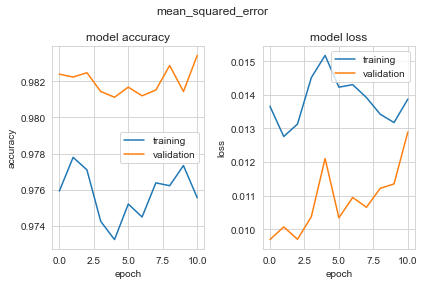

50000/50000 [==============================] - 2s 34us/sample - loss: 0.1012 - accuracy: 0.8136
Test loss: 0.0129
Test accuracy: 0.983
nadam


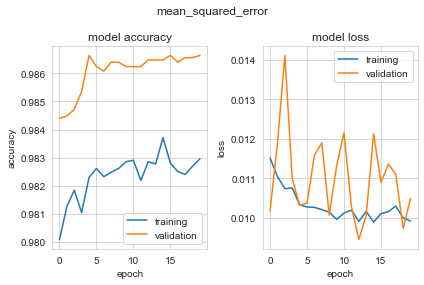

50000/50000 [==============================] - 1s 29us/sample - loss: 0.0874 - accuracy: 0.8486
Test loss: 0.0105
Test accuracy: 0.987
adagrad


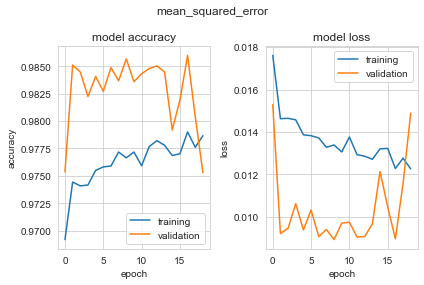

50000/50000 [==============================] - 2s 32us/sample - loss: 0.0678 - accuracy: 0.8862
Test loss: 0.0149
Test accuracy: 0.975
rmsprop


In [86]:
loss_functions = [
    'categorical_crossentropy',
    'categorical_hinge',
    'kullback_leibler_divergence',
    'mean_squared_error'
]
optimizers = ['sgd','adam','nadam','adagrad','rmsprop']

histories = []

for loss_function in loss_functions:
    for optimizer in optimizers:
        model = modelann
        model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
        history = model.fit(X_train4,y_train4, batch_size=128, epochs=20, verbose=False, validation_data=(X_test4,y_test4),callbacks=[es])
        plot_training_history(history, model, loss_function, optimizer)
        histories.append(history)

In [87]:
from keras.callbacks import ModelCheckpoint


In [118]:
modelann2=Sequential()
modelann2.add(Dense(256,activation='relu',input_dim=6))
modelann.add(Dropout(rate=0.2))

modelann2.add(Dense(128,activation='relu'))

modelann2.add(Dense(64,activation='relu'))
modelann2.add(Dense(32,activation='relu'))
modelann2.add(Dense(3,activation='softmax'))
optimizers2 = ['adam','nadam','adagrad','rmsprop']

#implement Early Stopping Maybe #Keras Tuner...


In [119]:
from keras.models import load_model
for i in range(5):
    mc = ModelCheckpoint('modelf'+str(i+1)+'.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=False)
    for optimizer in optimizers2: #Not Normalized
            model = modelann2
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
            model.fit(X_train4,y_train4,epochs=50,verbose=False,callbacks=[es,mc],validation_data=(X_test4,y_test4),batch_size=128)
            model.evaluate(X_test4,y_test4)
            model.evaluate(Xt.values,yann_t)
            
            print(optimizer)
    saved_modelf = tf.keras.models.load_model('modelf'+str(i+1)+'.h5')
    # evaluate the model

    test_acc = saved_modelf.evaluate(Xt.values,yann_t, verbose=0)
    print(test_acc)
      

50000/50000 [==============================] - 1s 29us/sample - loss: 0.5735 - accuracy: 0.8485
adam
50000/50000 [==============================] - 1s 27us/sample - loss: 0.3893 - accuracy: 0.8734
nadam
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1056 - accuracy: 0.9637
adagrad
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1636 - accuracy: 0.9379
rmsprop
[0.11243710769593716, 0.9601]
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1009 - accuracy: 0.9672
adam
50000/50000 [==============================] - 1s 28us/sample - loss: 0.3789 - accuracy: 0.8828
nadam
50000/50000 [==============================] - 1s 27us/sample - loss: 0.1092 - accuracy: 0.9657
adagrad
50000/50000 [==============================] - 1s 26us/sample - loss: 0.3910 - accuracy: 0.8719
rmsprop
[0.11009491251289845, 0.96504]
50000/50000 [==============================] - 1s 28us/sample - loss: 0.2166 - accuracy: 0.8992
adam
50000/50000 [===

In [124]:
 #Please consider the best model from above
saved_modelff = tf.keras.models.load_model('modelf2.h5')
ypredann=saved_modelff(Xt.values)

In [125]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_predannf = np.argmax(ypredann,axis=1)
yann_ta = np.argmax(yann_t,axis=1)
yann_ta

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [126]:
# Print f1, precision, and recall scores
print(precision_score(yann_ta, y_predannf , average="macro"))
print(recall_score(yann_ta, y_predannf , average="macro"))
print(f1_score(yann_ta, y_predannf , average="macro"))

0.919734085732249
0.9593370665069564
0.9370889802388587


In [127]:
acc_gen(yann_ta,y_predannf)

Confusion Matrix:
[[23800  1233   203]
 [  305  4428     2]
 [    5     0 20024]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     25236
           1       0.78      0.94      0.85      4735
           2       0.99      1.00      0.99     20029

    accuracy                           0.97     50000
   macro avg       0.92      0.96      0.94     50000
weighted avg       0.97      0.97      0.97     50000

Accuracy: 0.96504


<AxesSubplot:>

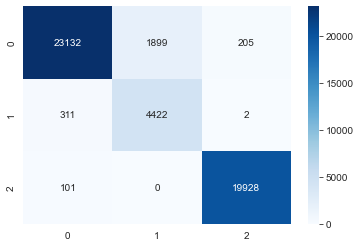

In [94]:
cnfm_ann = confusion_matrix(yann_ta,y_predannf)

sns.heatmap(cnfm_ann, cmap ='Blues', annot = True, fmt='d')#0-GALAXY,1-QUASAR,2-STAR Best Result So far

# Implementing Unsupervised Learning Method K-means Clustering

In [95]:
from sklearn.cluster import MiniBatchKMeans
total_clusters = 3
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters,batch_size=3072)
# Fitting the model to training set
kmeans.fit(X_train2)

MiniBatchKMeans(batch_size=3072, n_clusters=3)

In [96]:
kmeans.labels_[3]

1

In [97]:
def retrieve_info(cluster_labels,y_train2):

 #Associates most probable label with each cluster in KMeans model
 #returns: dictionary of clusters assigned to each label

# Initializing
    reference_labels={}
# For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train2[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [98]:
r=retrieve_info(kmeans.labels_,y_train2)
print(r)

{0: 1, 1: 0, 2: 2}


In [99]:
c = np.random.rand(3)
c

array([0.71982732, 0.21308862, 0.60154877])

In [100]:
reference_labels = retrieve_info(kmeans.labels_,y_train2)
number_labels = np.random.rand(len(kmeans.labels_)) 
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

In [101]:
number_labels.astype('int')

array([1, 1, 1, ..., 0, 1, 1])

In [102]:
print(number_labels[:20].astype('int'))
print(y_train2[:20])

[1 1 1 0 1 1 0 1 2 1 1 0 1 1 0 1 1 1 1 1]
27434    1
13400    1
883      0
7303     0
45124    1
874      1
45943    1
11458    1
23877    2
11       1
27813    0
10713    1
46014    0
3645     1
10448    1
41968    0
3813     1
4523     1
7231     1
39423    0
Name: class, dtype: int32


In [103]:
print(accuracy_score(number_labels,y_train2))

0.5742133333333334


In [104]:
def calculate_metrics(model,output):
    print('Number of clusters is {}\n'.format(model.n_clusters))
    print('Inertia : {}\n'.format(model.inertia_))
    print('Homogeneity : {}\n'.format(metrics.homogeneity_score(output,model.labels_)))

In [105]:
from sklearn import metrics
cluster_number = [10,16,36,64,144,256,512]
for i in cluster_number:
    total_clusters = len(np.unique(y_train2))
# Initialize the K-Means model
    kmeans = MiniBatchKMeans(n_clusters = i,random_state=1)
# Fitting the model to training set
    kmeans.fit(X_train2)
# Calculating the metrics
 
    calculate_metrics(kmeans,y_train2)
# Calculating reference_labels
    reference_labels = retrieve_info(kmeans.labels_,y_train2)
# ‘number_labels’ is a list which denotes the number displayed in image
    number_labels = np.zeros(len(kmeans.labels_))
    for j in range(len(kmeans.labels_)):
        number_labels[j] = reference_labels[kmeans.labels_[j]]
        number_labels[j].astype('int')
    print('Accuracy score : {}'.format(accuracy_score(number_labels,y_train2)))
    print('\n')

Number of clusters is 10

Inertia : 65.26750831061688

Homogeneity : 0.3064299327708562

Accuracy score : 0.6409333333333334


Number of clusters is 16

Inertia : 41.91420975717792

Homogeneity : 0.37567646134470145

Accuracy score : 0.73312


Number of clusters is 36

Inertia : 24.779197150233802

Homogeneity : 0.43409106833688166

Accuracy score : 0.76688


Number of clusters is 64

Inertia : 17.111367046410777

Homogeneity : 0.49822512494835125

Accuracy score : 0.79912


Number of clusters is 144

Inertia : 11.359502505145567

Homogeneity : 0.6156740121611385

Accuracy score : 0.8496533333333334


Number of clusters is 256

Inertia : 11.118405498957049

Homogeneity : 0.7163583988780335

Accuracy score : 0.8978666666666667


Number of clusters is 512

Inertia : 8.054262702868598

Homogeneity : 0.7653647582140833

Accuracy score : 0.91968




In [106]:
kmeans = MiniBatchKMeans(n_clusters = 256,random_state=1)
kmeans.fit(Xt_s)

MiniBatchKMeans(n_clusters=256, random_state=1)

In [107]:
reference_labels = retrieve_info(kmeans.labels_,y_ts)

In [108]:
number_labels = np.zeros(len(kmeans.labels_))
for j in range(len(kmeans.labels_)):
    number_labels[j] = reference_labels[kmeans.labels_[j]]
    number_labels[j].astype('int')
print('Accuracy score : {}'.format(accuracy_score(number_labels,y_ts)))

Accuracy score : 0.92076


In [109]:
acc_gen(y_ts,number_labels)

Confusion Matrix:
[[18835  1194     0]
 [ 2157 22979   100]
 [  112   399  4224]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     20029
           1       0.94      0.91      0.92     25236
           2       0.98      0.89      0.93      4735

    accuracy                           0.92     50000
   macro avg       0.93      0.91      0.92     50000
weighted avg       0.92      0.92      0.92     50000

Accuracy: 0.92076


<AxesSubplot:>

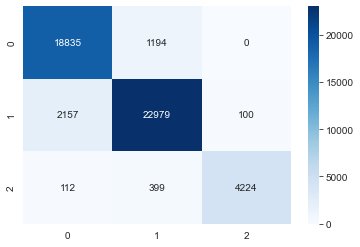

In [110]:
cnfm_kmc = confusion_matrix(y_ts,number_labels)

sns.heatmap(cnfm_kmc, cmap ='Blues', annot = True, fmt='d')